In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
# Só pegar as informações de ano	codmun	pop
populacao = pd.read_excel('pop_mun.xlsx', usecols=['ano', 'codmun', 'pop'])

In [2]:
dados = pd.read_csv('producao_tipo.csv')

C:\Users\maria\AppData\Local\Temp\ipykernel_18292\4140286855.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('producao_tipo.csv')


In [3]:
dados

,Uf,Ibge,Municipio,Atendimento Individual,Atendimento Odontológico,Procedimento,Visita Domiciliar,Mes,Ano
0,BA,290740.0,CATOLÂNDIA,504.0,246,323.0,921,JUL,2016.0
1,RN,241460.0,UPANEMA,1.46,303,173.0,3.403,JUL,2016.0
2,TO,170210.0,ARAGUAÍNA,5.638,1.075,805.0,17.534,JUL,2016.0
3,MG,312820.0,GUARACIABA,0.0,36,9.0,1.337,JUL,2016.0
4,PE,260030.0,AGRESTINA,2.529,851,847.0,6.979,JUL,2016.0
...,...,...,...,...,...,...,...,...,...
641589,MG,310490.0,BAEPENDI,4.094,445.0,5.158,19.734,ABR,2023.0
641590,RS,430760.0,ESTÂNCIA VELHA,11.356,665.0,22.039,1.667,ABR,2023.0
641591,TO,171700.0,PINDORAMA DO TOCANTINS,1.062,261.0,2.656,2.146,ABR,2023.0
641592,PR,412635.0,SERRANÓPOLIS DO IGUAÇU,773,166.0,3.470,1.275,ABR,2023.0


In [4]:
def adjust_value(valor):
    # Remove os pontos que são separadores de milhar
    if isinstance(valor, float):
        valor = str(valor)  # Converte float para string
    if isinstance(valor, int):
        valor = str(valor)  # Converte float para string

    if valor.endswith('.0'):
        # Se termina com '.0', transforma em int
        return int(valor[:-2])  # remove '.0' e converte para int
    else:
        # Verifica a quantidade de casas decimais
        parte_decimal = valor.split('.')[-1]

        if len(parte_decimal) == 1:
            # Se tem uma casa decimal, adiciona dois zeros
            return int(valor.replace(".", "") + '00')
        elif len(parte_decimal) == 2:
            # Se tem duas casas decimais, adiciona um zero
            return int(valor.replace(".", "") + '0')
        else:
            return int(valor.replace(".", ""))  # Caso não se encaixe, retorna só a parte inteira


In [5]:
meses_dict = {
    "JAN": "01",
    "FEV": "02",
    "MAR": "03",
    "ABR": "04",
    "MAI": "05",
    "JUN": "06",
    "JUL": "07",
    "AGO": "08",
    "SET": "09",
    "OUT": "10",
    "NOV": "11",
    "DEZ": "12"
}

In [6]:
# Corrigindo as colunas que deveriam ser string: IBGE, INE, Tipo Equipe

dados_final = dados
dados_final['Mes'] = dados_final['Mes'].replace(meses_dict)
dados_final['Ano'] = dados_final['Ano'].astype(int).astype(str)
dados_final['AnoMes'] = dados_final['Ano'] + dados_final['Mes']
dados_final['Ibge'] = dados_final['Ibge'].astype(int).astype(str)
dados_final['Individual'] = dados_final['Atendimento Individual'].apply(adjust_value)
dados_final['Odonto'] = dados_final['Atendimento Odontológico'].apply(adjust_value)
dados_final['Procedimento2'] = dados_final['Procedimento'].apply(adjust_value)
dados_final['Domiciliar'] = dados_final['Visita Domiciliar'].apply(adjust_value)

In [7]:
dados_final

,Uf,Ibge,Municipio,Atendimento Individual,Atendimento Odontológico,Procedimento,Visita Domiciliar,Mes,Ano,AnoMes,Individual,Odonto,Procedimento2,Domiciliar
0,BA,290740,CATOLÂNDIA,504.0,246,323.0,921,07,2016,201607,504,246,323,921
1,RN,241460,UPANEMA,1.46,303,173.0,3.403,07,2016,201607,1460,303,173,3403
2,TO,170210,ARAGUAÍNA,5.638,1.075,805.0,17.534,07,2016,201607,5638,1075,805,17534
3,MG,312820,GUARACIABA,0.0,36,9.0,1.337,07,2016,201607,0,360,9,1337
4,PE,260030,AGRESTINA,2.529,851,847.0,6.979,07,2016,201607,2529,851,847,6979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641589,MG,310490,BAEPENDI,4.094,445.0,5.158,19.734,04,2023,202304,4094,445,5158,19734
641590,RS,430760,ESTÂNCIA VELHA,11.356,665.0,22.039,1.667,04,2023,202304,11356,665,22039,1667
641591,TO,171700,PINDORAMA DO TOCANTINS,1.062,261.0,2.656,2.146,04,2023,202304,1062,261,2656,2146
641592,PR,412635,SERRANÓPOLIS DO IGUAÇU,773,166.0,3.470,1.275,04,2023,202304,773,166,3470,1275


In [21]:
#Filtra só São Paulo
atendimentos_sp = dados_final[(dados_final.Municipio == "SÃO PAULO") & (dados_final.Ano.isin(['2024','2023','2022']))].sort_values(by='AnoMes')

In [22]:
atendimentos_sp

,Uf,Ibge,Municipio,Atendimento Individual,Atendimento Odontológico,Procedimento,Visita Domiciliar,Mes,Ano,AnoMes,Individual,Odonto,Procedimento2,Domiciliar
510874,SP,355030,SÃO PAULO,1.164.438,114.593,1.406.579,1.391.463,01,2022,202201,1164438,114593,1406579,1391463
517830,SP,355030,SÃO PAULO,1.109.369,129.455,1.327.604,1.158.219,02,2022,202202,1109369,129455,1327604,1158219
428180,SP,355030,SÃO PAULO,1.324.919,151.924,1.606.352,1.319.284,03,2022,202203,1324919,151924,1606352,1319284
90926,SP,355030,SÃO PAULO,1.188.694,155.293,1.427.627,1.097.485,04,2022,202204,1188694,155293,1427627,1097485
339552,SP,355030,SÃO PAULO,1.447.696,164.971,1.707.614,1.624.333,05,2022,202205,1447696,164971,1707614,1624333
552790,SP,355030,SÃO PAULO,1.342.596,151.294,1.680.059,1.492.150,06,2022,202206,1342596,151294,1680059,1492150
231131,SP,355030,SÃO PAULO,1.421.501,174.115,1.726.314,1.603.282,07,2022,202207,1421501,174115,1726314,1603282
450059,SP,355030,SÃO PAULO,1.625.576,210.242,1.877.387,1.761.976,08,2022,202208,1625576,210242,1877387,1761976
259642,SP,355030,SÃO PAULO,1.398.885,188.264,1.760.957,1.719.496,09,2022,202209,1398885,188264,1760957,1719496
585536,SP,355030,SÃO PAULO,1.395.097,182.387,1.796.071,1.619.064,10,2022,202210,1395097,182387,1796071,1619064


In [49]:
pop_sp = populacao[populacao.codmun == 355030]
pop_sp['Ano'] = pop_sp['ano'].astype(int).astype(str)

C:\Users\maria\AppData\Local\Temp\ipykernel_18292\3758602971.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
pop_sp

,ano,codmun,pop,Ano
3829,2010,355030,11536254,2010
9399,2011,355030,11617017,2011
14969,2012,355030,11698564,2012
20539,2013,355030,11779406,2013
26109,2014,355030,11860285,2014
31679,2015,355030,11943037,2015
37249,2016,355030,12022916,2016
42819,2017,355030,12099887,2017
48389,2018,355030,12176866,2018
53959,2019,355030,12252023,2019


População para 2022, 2023 são iguais. Ambas 11451999

In [57]:
# # Mesclar os DataFrames com base no ano
# merged_df = pd.merge(atendimentos_sp, pop_sp, left_on='Ano', right_on='Ano')

# # Calcular atend_por_pop_sp
# atend_por_pop_sp = merged_df['Individual'] / merged_df['pop']

# # Adicionar o resultado ao DataFrame original se necessário
# merged_df['atend_por_pop_sp'] = atend_por_pop_sp
atendimentos_sp['Individual por habitante'] = atendimentos_sp['Individual']/11451999


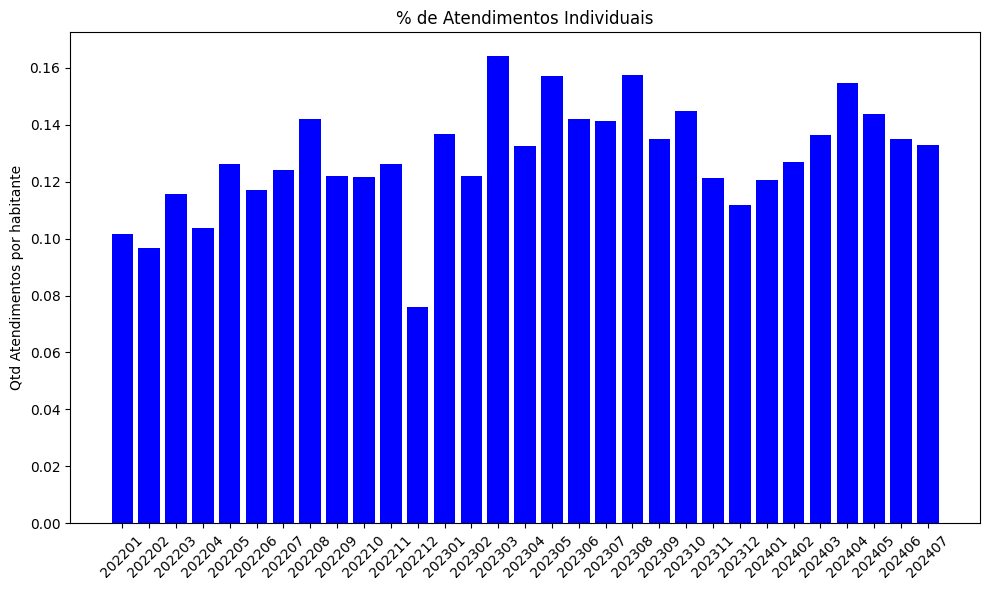

In [59]:
# Gráfico

# Definindo o índice
# atendimentos_sp.set_index('AnoMes', inplace=True)

# Criando o gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
plt.bar(atendimentos_sp['AnoMes'], atendimentos_sp['Individual por habitante'], color='blue')
# Adicionando título e rótulos
plt.title('% de Atendimentos Individuais')
# plt.xlabel('Período')
plt.ylabel('Qtd Atendimentos por habitante')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo X
plt.tight_layout()  # Ajustar layout para melhor visualização

# Mostrar o gráfico
plt.show()

In [68]:
atendimentos_sp.set_index('AnoMes', inplace=True)
serie_temporal = atendimentos_sp['Individual por habitante']

In [99]:
# Definir o tamanho do conjunto de teste
tamanho_teste = 3
treino = serie_temporal.iloc[:-tamanho_teste]
teste = serie_temporal.iloc[-tamanho_teste:]

In [100]:
result = adfuller(serie_temporal)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.046352840149717
p-value: 0.030786565550861157


In [101]:
# TODO: Ajustar modelo ARIMA(1,1,1) 
model = ARIMA(treino, order=(1, 1, 1))
model_fit = model.fit()

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil

In [102]:
# Resumo do modelo
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Individual por habitante   No. Observations:                   28
Model:                       ARIMA(1, 1, 1)   Log Likelihood                  70.525
Date:                      Fri, 27 Sep 2024   AIC                           -135.049
Time:                              22:39:55   BIC                           -131.162
Sample:                                   0   HQIC                          -133.893
                                       - 28                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6631      0.205     -3.232      0.001      -1.065      -0.261
ma.L1          0.0759      0.253      0.300      0.764      -0.420       0.572
sigm

In [103]:
# Previsão de 10 períodos à frente
previsoes = model_fit.forecast(steps=tamanho_teste)
print(previsoes)

28    0.144356
29    0.151146
30    0.146643
Name: predicted_mean, dtype: float64


C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [104]:
# Calcular métricas
mae = mean_absolute_error(teste, previsoes)
mse = mean_squared_error(teste, previsoes)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((teste - previsoes) / teste)) * 100

print(f"MAE: {mae:.3}")
print(f"MSE: {mse:.3}")
print(f"RMSE: {rmse:.3}")
print(f"MAPE: {mape:.3}")

MAE: 0.0102
MSE: 0.00015
RMSE: 0.0122
MAPE: nan


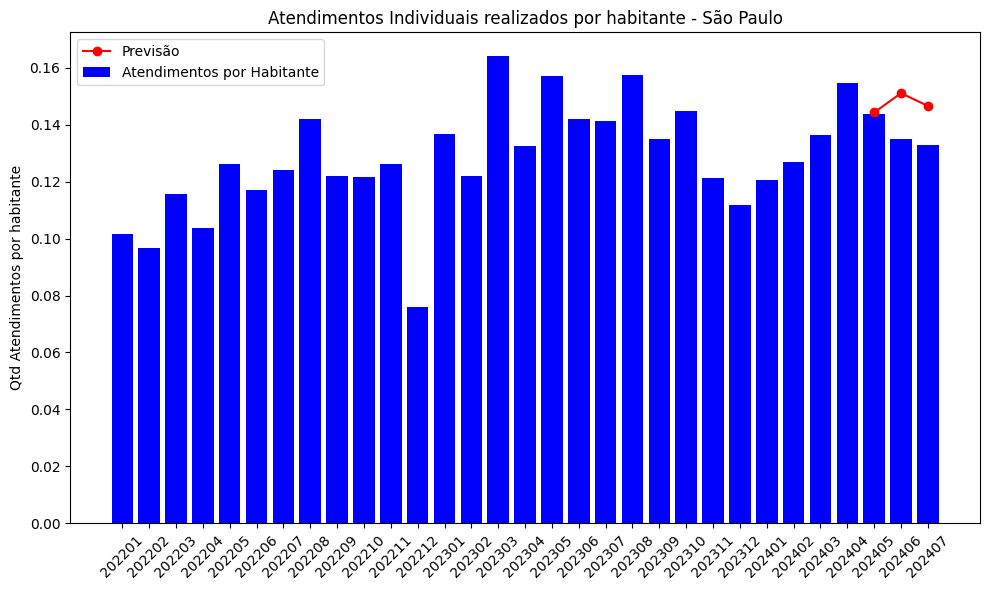

In [122]:
# Gráfico

# Definindo o índice
# atendimentos_sp.set_index('AnoMes', inplace=True)

# Criando o gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
plt.bar( atendimentos_sp.index, atendimentos_sp['Individual por habitante'], color='blue', label='Atendimentos por Habitante')
plt.plot( teste.index, previsoes, color='red' , marker='o', label = 'Previsão')
# Adicionando título e rótulos
plt.title('Atendimentos Individuais realizados por habitante - São Paulo')
# plt.xlabel('Período')
plt.ylabel('Qtd Atendimentos por habitante')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo X
plt.tight_layout()  # Ajustar layout para melhor visualização
plt.legend()
# Mostrar o gráfico
plt.show()